In [13]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import OrderedDict
sns.set()

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler, QuantileTransformer
# Algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from tools import *

DATA_DIR = Path('../../data')
PROC_DIR = Path(DATA_DIR / 'processed')
    

flow_columns = ['R [Rsun]', 'B [G]', 'alpha [deg]']
MAX_CLUSTERS = 8

# Load data

In [14]:
filenames = [f for f in PROC_DIR.iterdir()]

flows_dict = OrderedDict()
for f in filenames:
    flows_dict[f.stem] = pd.read_csv(f, usecols=['R [Rsun]', 'B [G]', 'alpha [deg]']) 

## Scale Inputs

In [15]:

# # concat flows
# scaled_flows = list(flows_dict.values())
# scaled_flows = pd.concat(scaled_flows, axis=0)

# scaler = MinMaxScaler((-1,1))
# scaler.fit(scaled_flows)
# scaled_flows = scaler.transform(scaled_flows)

# scaled_flows = pd.DataFrame(scaled_flows, columns=flow_columns)
# print(scaled_flows.shape)
# print(scaled_flows.head())

In [16]:
# concat flows
scaled_flows = list(flows_dict.values())
scaled_flows = pd.concat(scaled_flows, axis=0)

scaler = QuantileTransformer()
scaler.fit(scaled_flows)
scaled_flows = scaler.transform(scaled_flows)

scaled_flows = pd.DataFrame(scaled_flows, columns=flow_columns)
print(scaled_flows.shape)
print(scaled_flows.head())

(7533440, 3)
   R [Rsun]     B [G]  alpha [deg]
0  0.000000  0.835081     0.245097
1  0.002002  0.834965     0.245348
2  0.003004  0.834849     0.245548
3  0.005853  0.834742     0.245752
4  0.006948  0.834637     0.245959


# All Columns

In [17]:
# separate into file series
scaled_all = [scaled_flows.iloc[i*640:i*640+640, :] for i in range(len(scaled_flows) // 640)]
scaled_all = [flow.values for flow in scaled_all]
scaled_all = np.array([flow.ravel() for flow in np.array(scaled_all)])
scaled_all.shape

(11771, 1920)

In [18]:
scaled_all[0][:20]

array([0.        , 0.83508145, 0.2450972 , 0.00200203, 0.83496512,
       0.24534821, 0.0030045 , 0.83484856, 0.24554808, 0.0058527 ,
       0.83474242, 0.24575159, 0.0069476 , 0.83463749, 0.24595878,
       0.00800803, 0.83453233, 0.24616969, 0.00900907, 0.83442695])

## PCA

In [19]:
pca_640 = PCA(n_components=640)
pca_640.fit(scaled_all)
transf_pca_640 = pca_640.transform(scaled_all)

print("Variance by explained by all components: {:.2f}".format(sum(pca_640.explained_variance_ratio_)*100))

Variance by explained by all components: 100.00


[Text(0.5, 0, 'Number of Components'),
 Text(0, 0.5, 'Cumulative Explained Variance (%)'),
 (0.0, 6.0)]

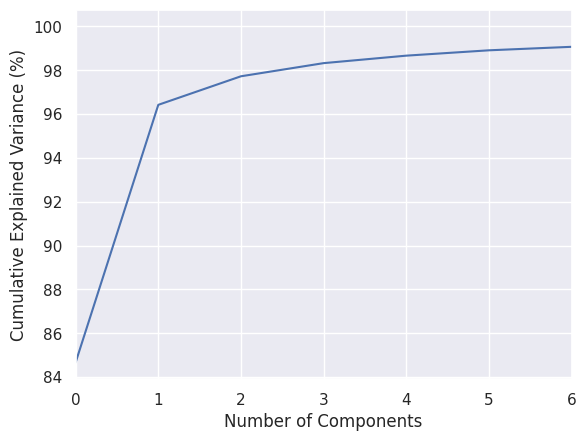

In [20]:
lp = sns.lineplot(np.cumsum(pca_640.explained_variance_ratio_*100))
lp.set(xlabel='Number of Components', ylabel='Cumulative Explained Variance (%)', xlim=(0, 6))

> **Dimensionality**: Most of the data (about 98%) is explained by only 2 components

In [21]:
pca = PCA(n_components=2)
transformed_all = pca.fit_transform(scaled_all)
transformed_all.shape

(11771, 2)

<AxesSubplot: >

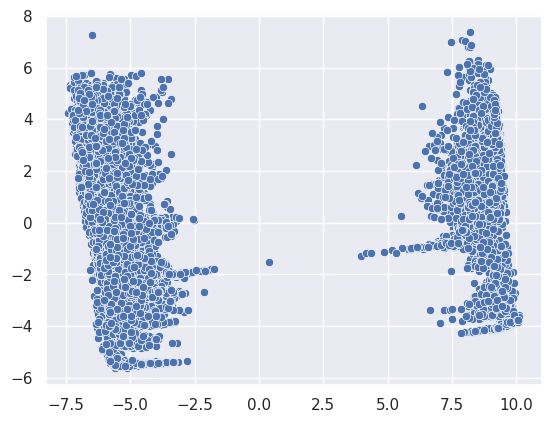

In [22]:
sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1])

## K-Means

[Text(0.5, 0, 'Number of clusters'),
 Text(0, 0.5, 'Distortion'),
 Text(0.5, 1.0, 'Elbow Plot')]

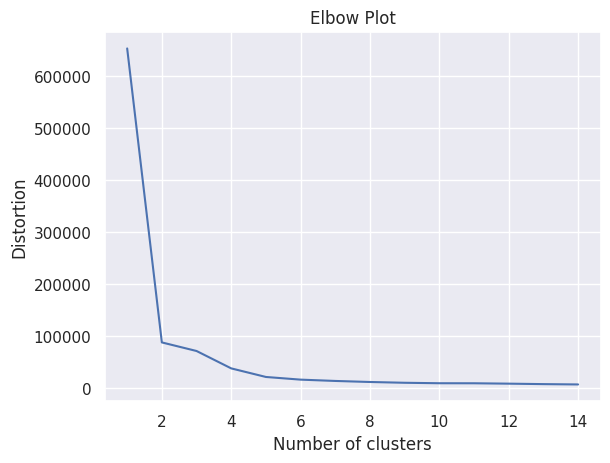

In [23]:
# Elbow Test
distortions = []
K = range(1, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, max_iter=5000, n_init='auto')
    kmeans.fit(transformed_all)
    distortions.append(kmeans.inertia_)
    
ep = sns.lineplot(x=K, y=distortions)
ep.set(xlabel='Number of clusters', ylabel='Distortion', title='Elbow Plot')

In [24]:
silhouette_scores = {"n_clusters" : [], "silhouette_score" : []}
for i in range(2, 10):
    kmeans = KMeans(n_clusters=i, max_iter=5000, n_init='auto')
    labels = kmeans.fit_predict(transformed_all)
    silhouette_avg = silhouette_score(transformed_all, labels)
    silhouette_scores["n_clusters"].append(i)
    silhouette_scores["silhouette_score"].append(silhouette_avg)
pd.DataFrame(silhouette_scores, index=None)    

n_clusters  silhouette_score
0           2          0.779616
1           3          0.649089
2           4          0.606611
3           5          0.524044
4           6          0.490997
5           7          0.469819
6           8          0.445699
7           9          0.434932

In [25]:
kmeans = KMeans(n_clusters=2,max_iter=500, n_init='auto')
pca_kmeans_labels = kmeans.fit_predict(scaled_all)
nclusters = len(set(pca_kmeans_labels))

<AxesSubplot: >

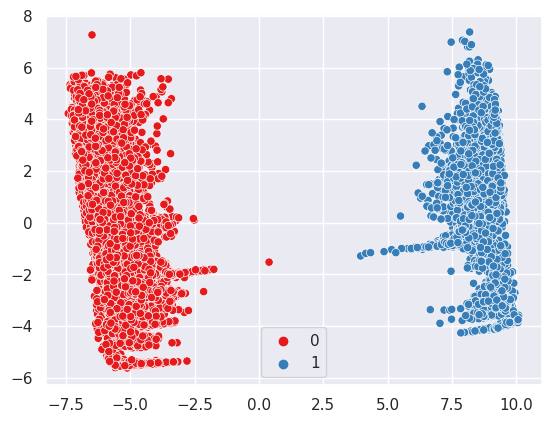

In [26]:
sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=pca_kmeans_labels, palette='Set1')

### Original Data

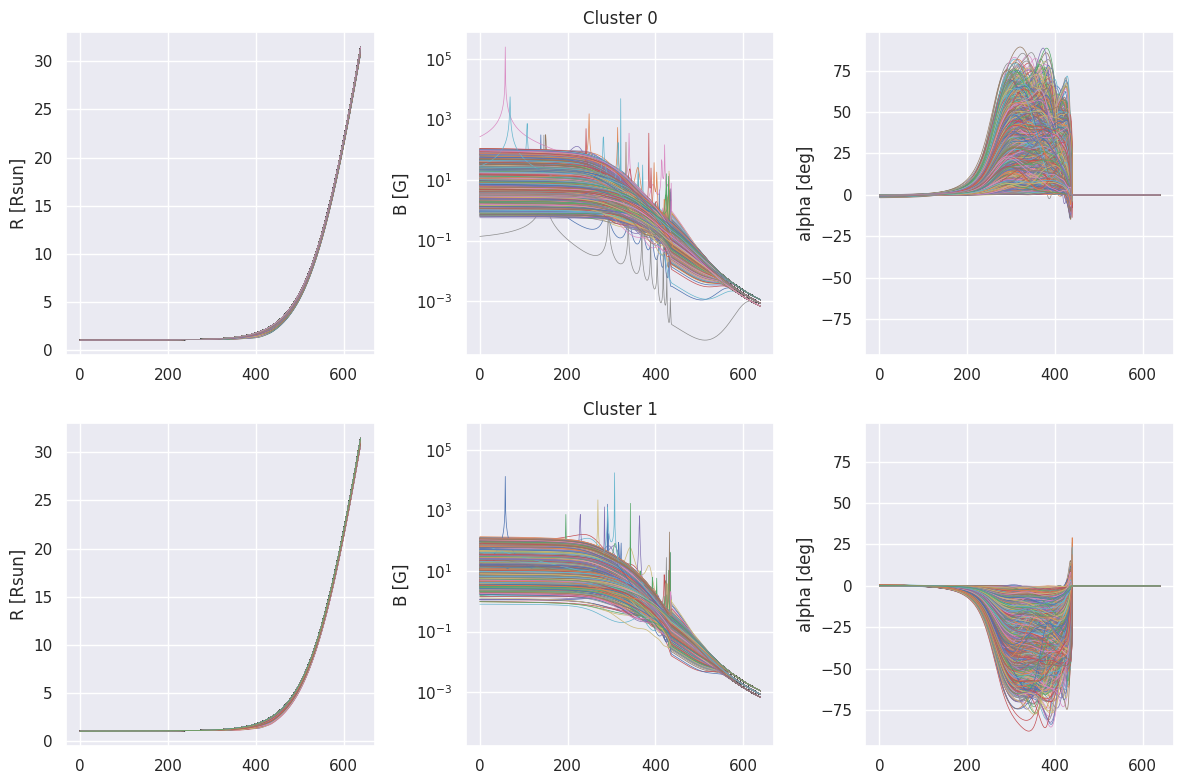

In [27]:
plot_unscaled_clusters(pca_kmeans_labels, nclusters, flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Number of files')]

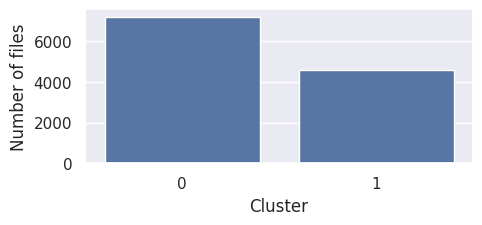

In [28]:
fig, ax = plt.subplots(figsize=(5, 2))
bp = sns.countplot(x=pca_kmeans_labels, ax=ax, color='b')
bp.set(xlabel='Cluster', ylabel='Number of files')

### Grid Search

In [29]:
# %%capture
# subdir = OUT_DIR / 'kmeans'
# if not subdir.exists():
#     subdir.mkdir(parents=True)
    
# for k in range(2, 5):
#     kmeans = KMeans(n_clusters=k, max_iter=5000, n_init='auto')
#     kmeans_labels = kmeans.fit_predict(transformed_all)
    
#     sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=kmeans_labels, palette='Set1')
#     plt.savefig(subdir / f'scatter_{k}.png', dpi=200)
#     plot_unscaled_clusters(kmeans_labels, k, flows_dict, flow_columns, save_path=subdir / f'unscaled_{k}.png', yscale={'B [G]': 'log'})

## Hierarchical Clustering

In [30]:
agg = AgglomerativeClustering(compute_distances=True, n_clusters=2, compute_full_tree=True, linkage='average')
agg = agg.fit(transformed_all)
nclusters = len(set(agg.labels_))

Text(0.5, 0, 'Number of points in node')

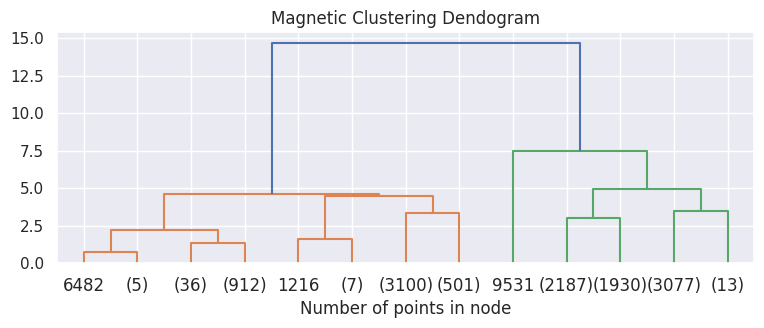

In [31]:
plt.figure(figsize=(9, 3))
plt.title("Magnetic Clustering Dendogram")
plot_dendrogram(agg, truncate_mode='level', p=3)
plt.xlabel("Number of points in node")

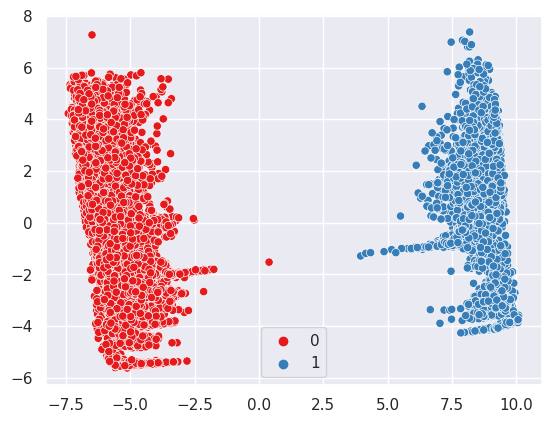

In [32]:
sp = sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=agg.labels_, palette='Set1')
# sp.legend_.remove()


### Original Data

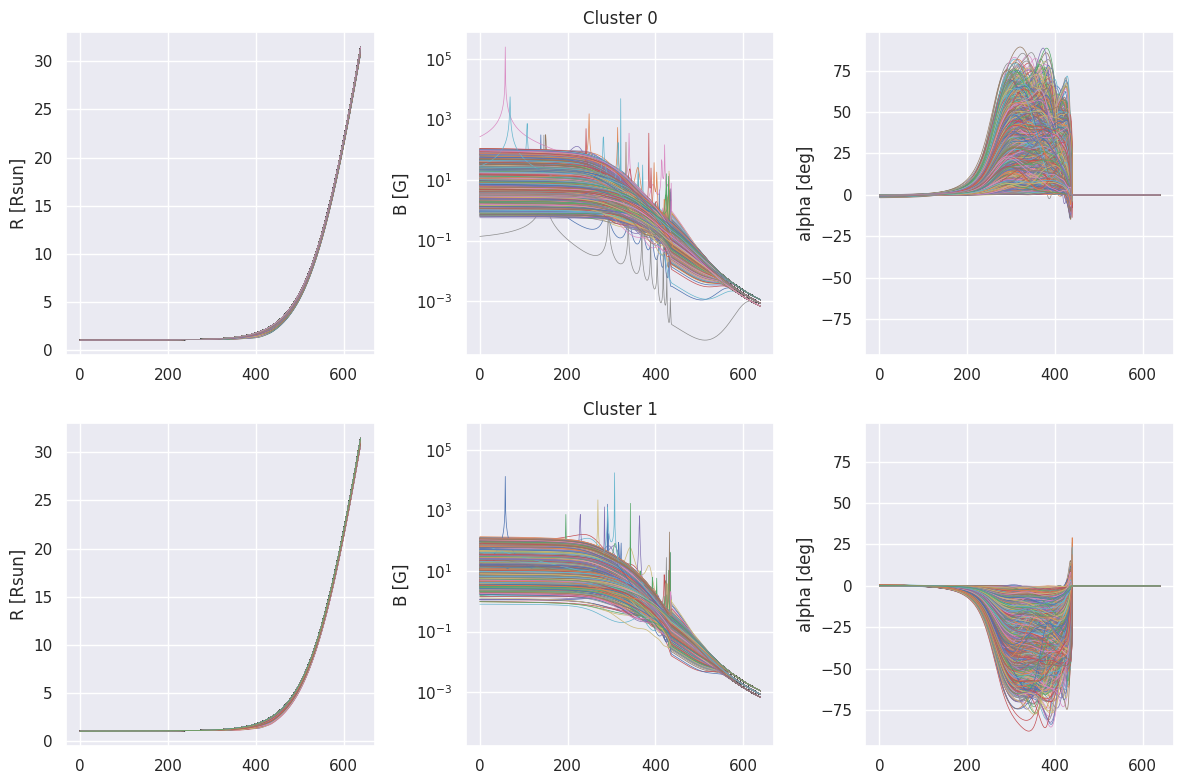

In [33]:
plot_unscaled_clusters(agg.labels_, nclusters, flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

<AxesSubplot: ylabel='count'>

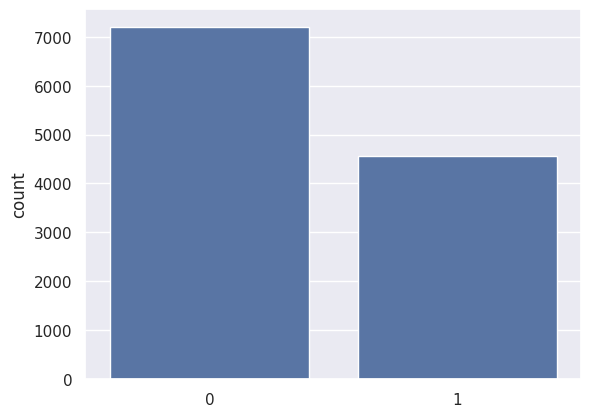

In [34]:
sns.countplot(x=agg.labels_, color='b')

### Grid Search

In [35]:
# %%capture
# sub_dir = OUT_DIR / 'hierarchical'
# if not sub_dir.exists():
#     sub_dir.mkdir()
    
# for i in range(2, MAX_CLUSTERS):
#     agg = AgglomerativeClustering(compute_distances=True, n_clusters=i, compute_full_tree=True, linkage='average')
#     agg = agg.fit(transformed_all)
    
#     sp = sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=agg.labels_, palette='Set1') 
#     plt.savefig(sub_dir / f'scatter_{i}.png', dpi=200)
    
#     plot_unscaled_clusters(agg.labels_, i, flows_dict, flow_columns, save_path=sub_dir / f'unscaled_{i}.png', yscale={'B [G]': 'log'}) 
    

## DBSCAN

In [36]:
dbscan = DBSCAN(eps=0.5, min_samples=5, n_jobs=2)
dbscan_labels = dbscan.fit_predict(transformed_all)
nclusters = len(set(dbscan_labels))

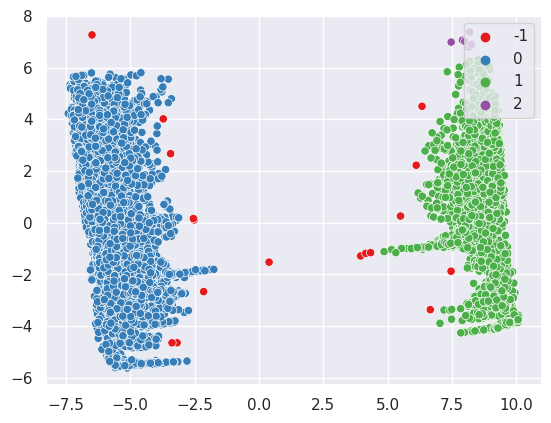

In [37]:
sp = sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=dbscan_labels, palette='Set1')
plt.legend(loc='upper right')

### Original Data

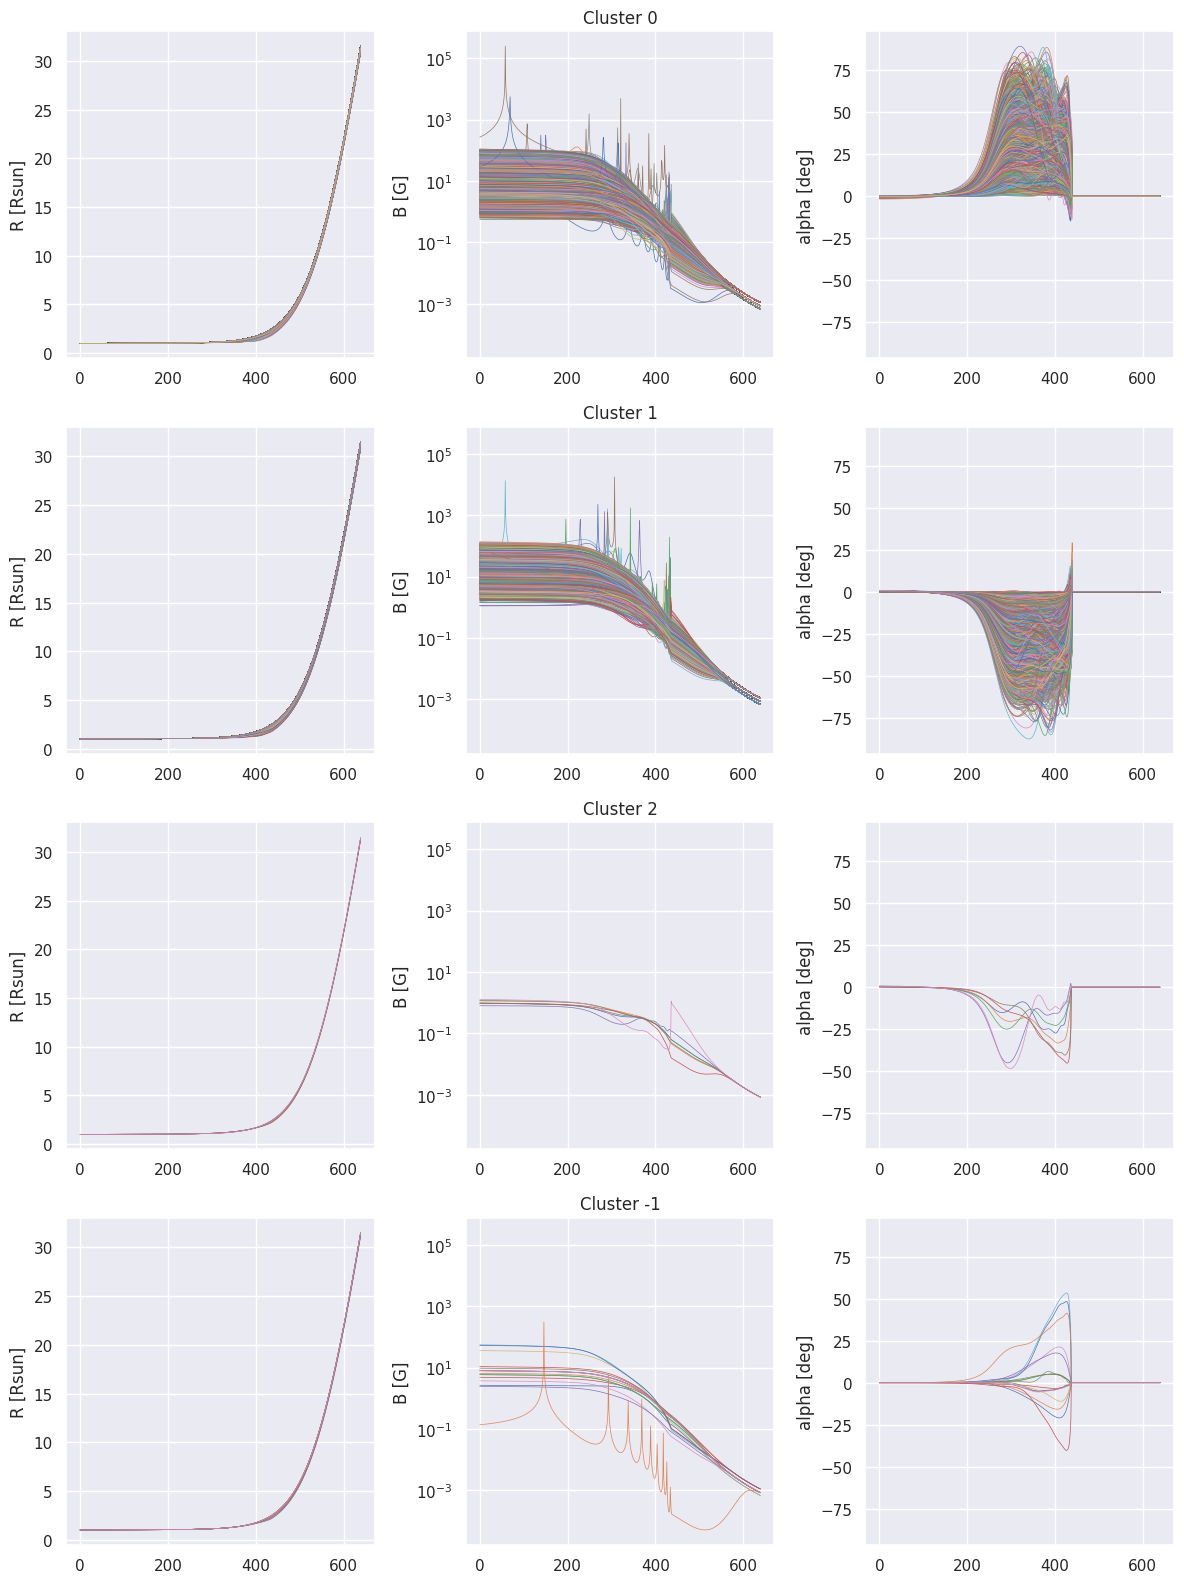

In [38]:
plot_unscaled_clusters(dbscan_labels, nclusters, flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

<AxesSubplot: ylabel='count'>

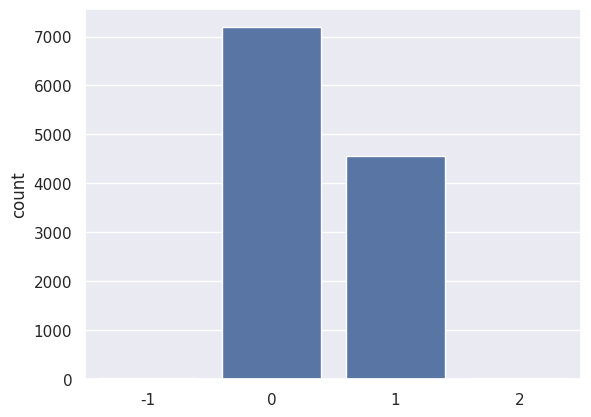

In [39]:
sns.countplot(x=dbscan_labels, color='b')

### Grid Search

In [40]:
# %%capture
# sub_dir = OUT_DIR / 'dbscan'
# if not sub_dir.exists():
#     sub_dir.mkdir()


# for k in range(3, 640):
#     for i in np.arange(0.05, 0.9, 0.05):
#         dbscan = DBSCAN(eps=i, min_samples=k, n_jobs=-1)
#         dbscan_labels = dbscan.fit_predict(transformed_all)
        
#         nclusters = len(set(dbscan_labels))
#         if (nclusters > MAX_CLUSTERS or nclusters < 2):
#             continue
        
#         save_i = int(i*100)
#         sp = sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=dbscan_labels, palette='Set1')
#         plt.legend(loc='upper right')
#         plt.savefig(sub_dir / f'scatter_{k}_{save_i}.png', dpi=200)
        
#         plot_unscaled_clusters(dbscan_labels, len(set(dbscan_labels)), flows_dict, flow_columns, 
#                                save_path=sub_dir / f'unscaled_{k}_{save_i}.png', yscale={'B [G]': 'log'})
    

# Magnetic Field + Inclination

In [41]:
# separate into file series
scaled_mag_inc = [scaled_flows.iloc[i*640:i*640+640, 1:] for i in range(len(scaled_flows) // 640)]
scaled_mag_inc = [flow.values for flow in scaled_mag_inc]
scaled_mag_inc = np.array([flow.ravel() for flow in np.array(scaled_mag_inc)])
scaled_mag_inc.shape

(11771, 1280)

## PCA

In [42]:
pca_640 = PCA(n_components=640)
pca_640.fit(scaled_mag_inc)
transf_pca_640 = pca_640.transform(scaled_mag_inc)

print("Variance by explained by all components: {:.2f}".format(sum(pca_640.explained_variance_ratio_)*100))

Variance by explained by all components: 100.00


[Text(0.5, 0, 'Number of Components'),
 Text(0, 0.5, 'Cumulative Explained Variance (%)'),
 (0.0, 6.0)]

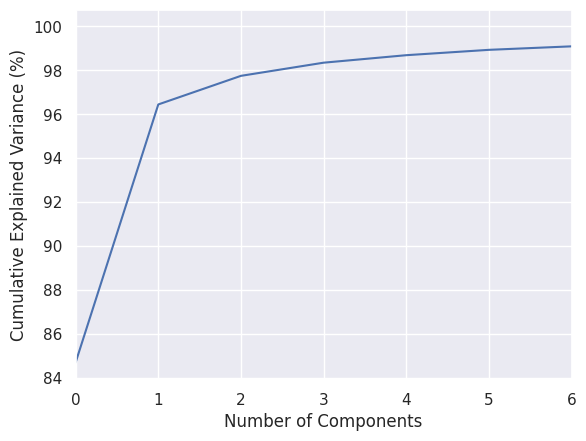

In [43]:
lp = sns.lineplot(np.cumsum(pca_640.explained_variance_ratio_*100))
lp.set(xlabel='Number of Components', ylabel='Cumulative Explained Variance (%)', xlim=(0, 6))

In [44]:
pca = PCA(n_components=2)
transformed_mag_inc = pca.fit_transform(scaled_mag_inc)
transformed_mag_inc

array([[-4.86709186, -1.07599434],
       [-4.96854656, -2.67889132],
       [ 8.43887118,  4.67143389],
       ...,
       [-6.33512748,  2.31860732],
       [ 8.87540087,  3.105855  ],
       [ 7.93848004,  1.86800252]])

<AxesSubplot: >

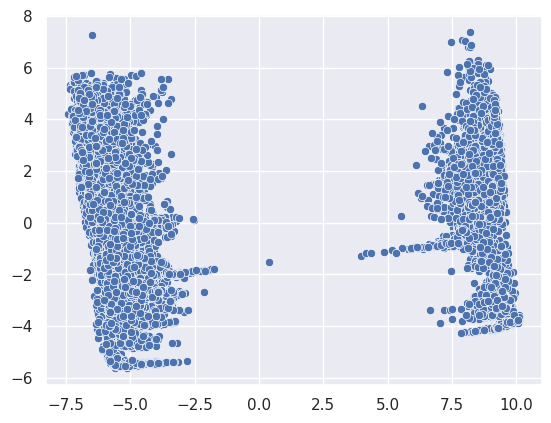

In [45]:
sns.scatterplot(x=transformed_mag_inc[:, 0], y=transformed_mag_inc[:, 1])

## K-Means

[Text(0.5, 0, 'Number of clusters'),
 Text(0, 0.5, 'Distortion'),
 Text(0.5, 1.0, 'Elbow Plot')]

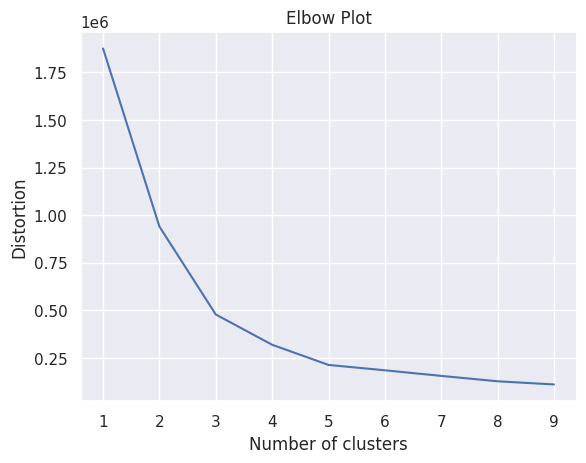

In [46]:
# Elbow Test
distortions = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, max_iter=5000, n_init='auto')
    kmeans.fit(scaled_flows)
    distortions.append(kmeans.inertia_)
    
ep = sns.lineplot(x=K, y=distortions)
ep.set(xlabel='Number of clusters', ylabel='Distortion', title='Elbow Plot')
    

In [47]:
kmeans = KMeans(n_clusters=8,max_iter=5000, n_init='auto')
pca_kmeans_mag_inc_labels = kmeans.fit_predict(transformed_mag_inc)
nclusters = len(set(pca_kmeans_mag_inc_labels))

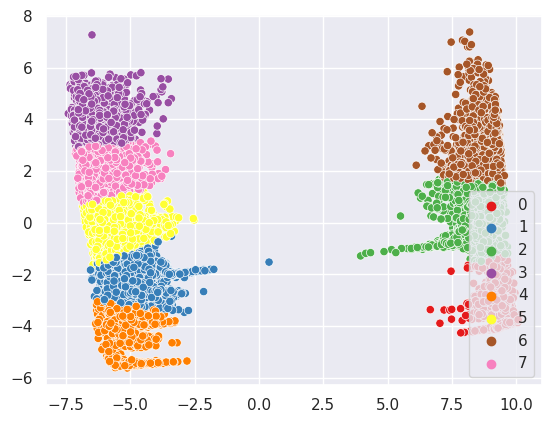

In [48]:
sp = sns.scatterplot(x=transformed_mag_inc[:, 0], y=transformed_mag_inc[:, 1], hue=pca_kmeans_mag_inc_labels, palette='Set1')
plt.legend(loc='lower right')

### Original Data

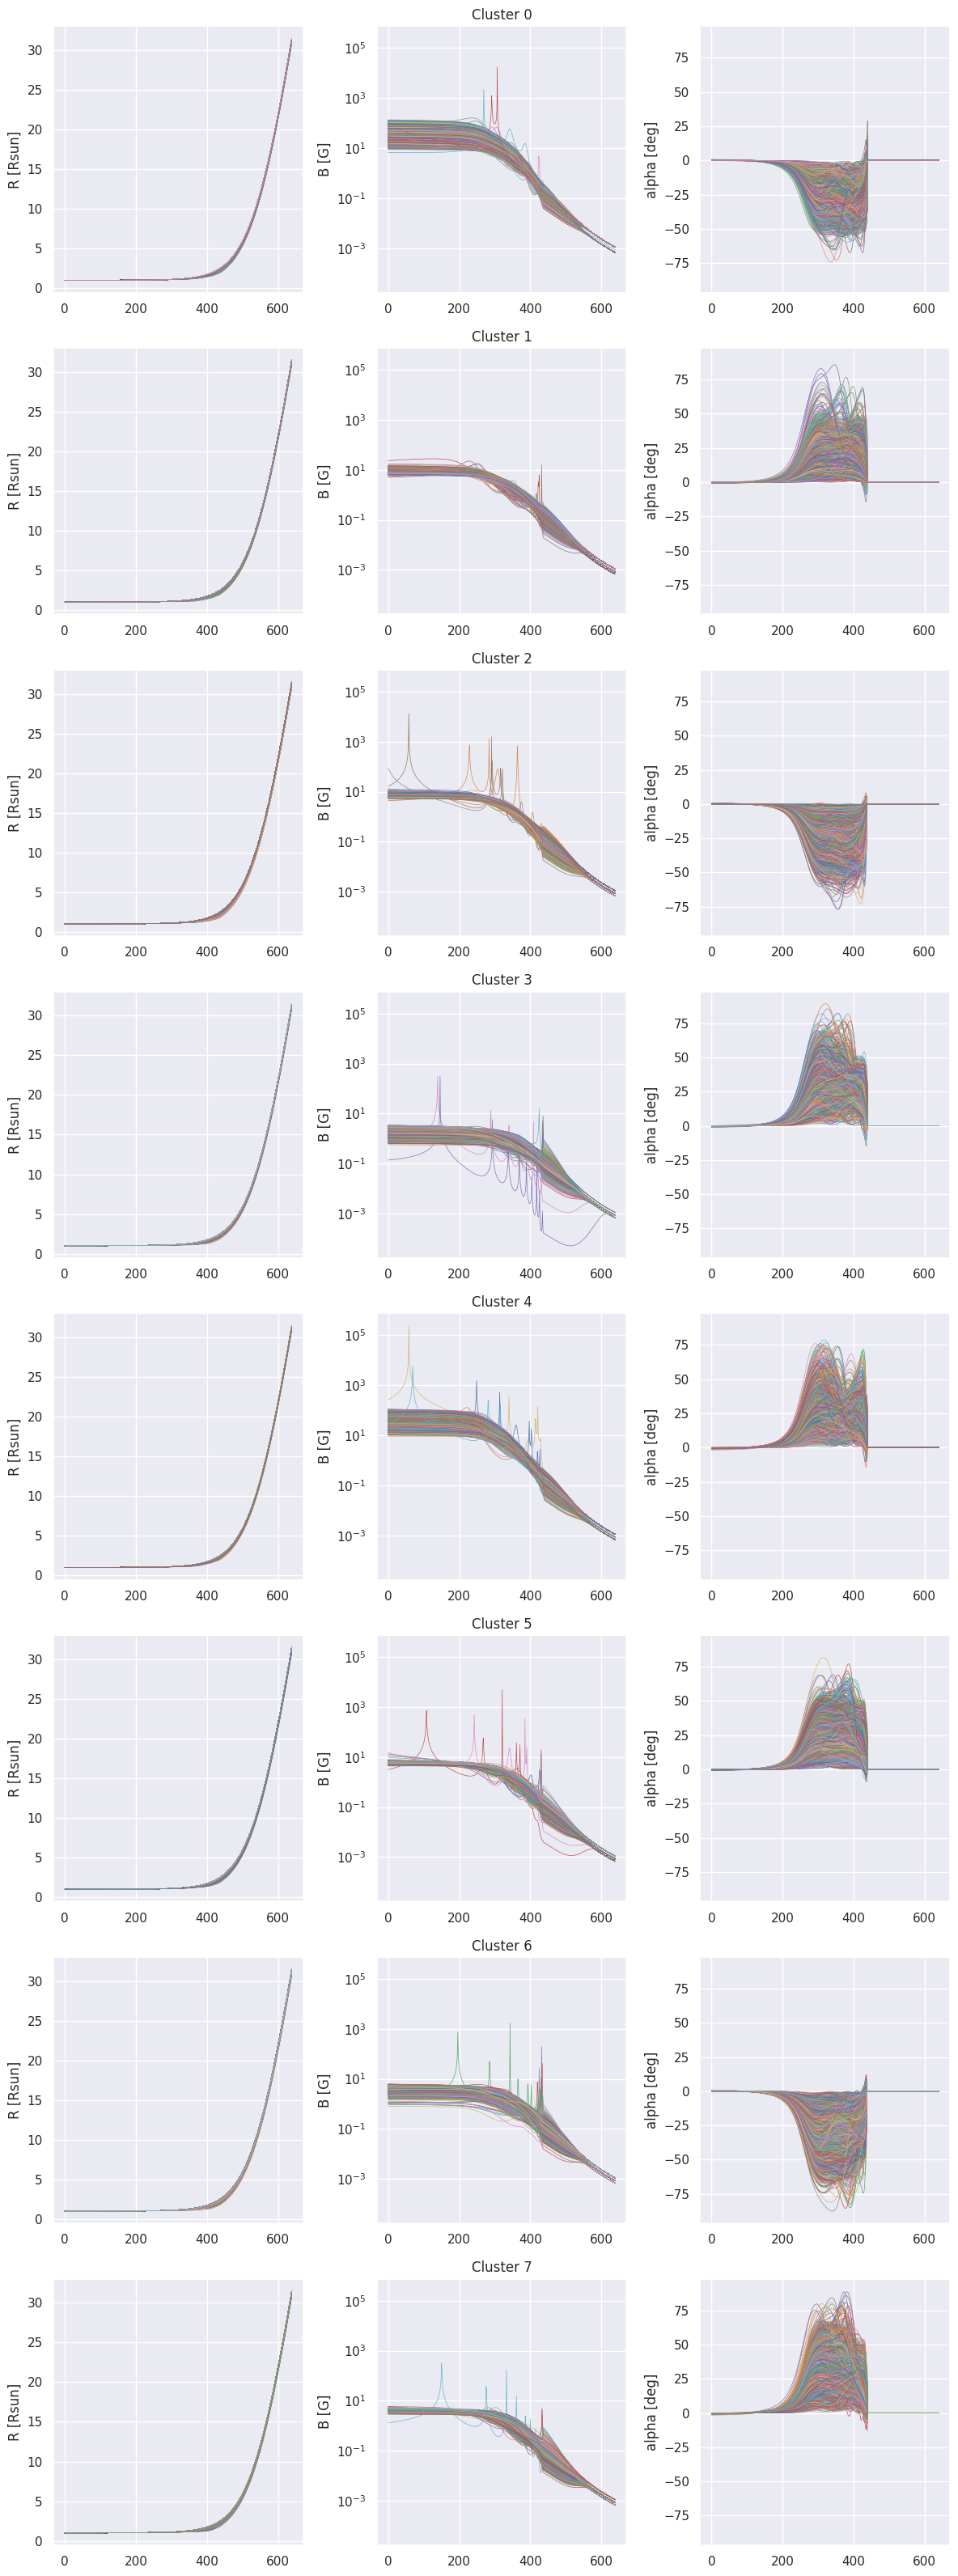

In [49]:
plot_unscaled_clusters(pca_kmeans_mag_inc_labels, nclusters, flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Number of files')]

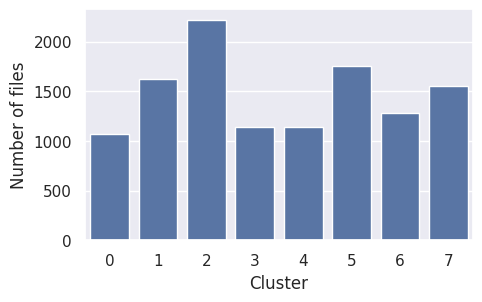

In [50]:
fig, ax = plt.subplots(figsize=(5, 3))
bp = sns.countplot(x=pca_kmeans_mag_inc_labels, ax=ax, color='b')
bp.set(xlabel='Cluster', ylabel='Number of files')

## Hierarchical Clustering

In [51]:
agg = AgglomerativeClustering(compute_distances=True, n_clusters=4, compute_full_tree=True, linkage='average')
agg = agg.fit(transformed_mag_inc)
nclusters = len(set(agg.labels_))

Text(0.5, 0, 'Number of points in node')

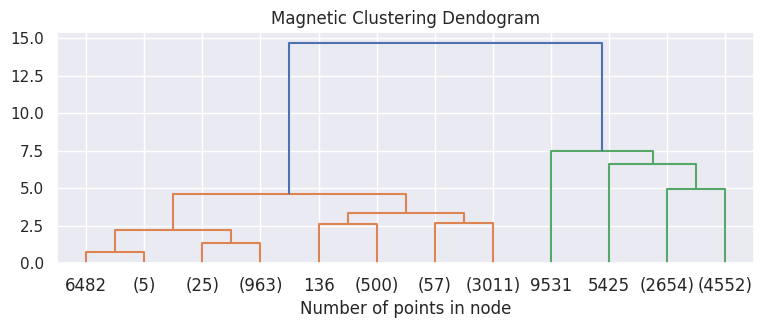

In [52]:
plt.figure(figsize=(9, 3))
plt.title("Magnetic Clustering Dendogram")
plot_dendrogram(agg, truncate_mode='level', p=3)
plt.xlabel("Number of points in node")

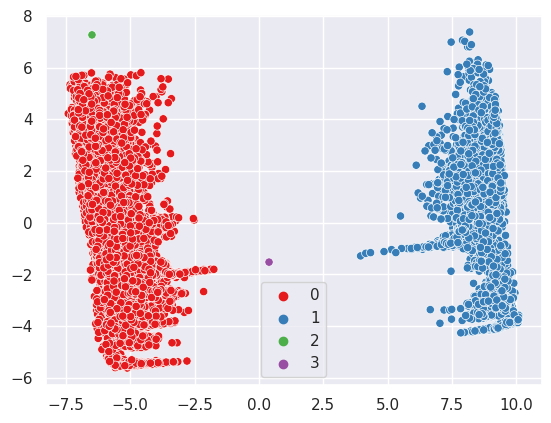

In [53]:
sp = sns.scatterplot(x=transformed_mag_inc[:, 0], y=transformed_mag_inc[:, 1], hue=agg.labels_, palette='Set1')
# sp.legend_.remove()


### Original Data

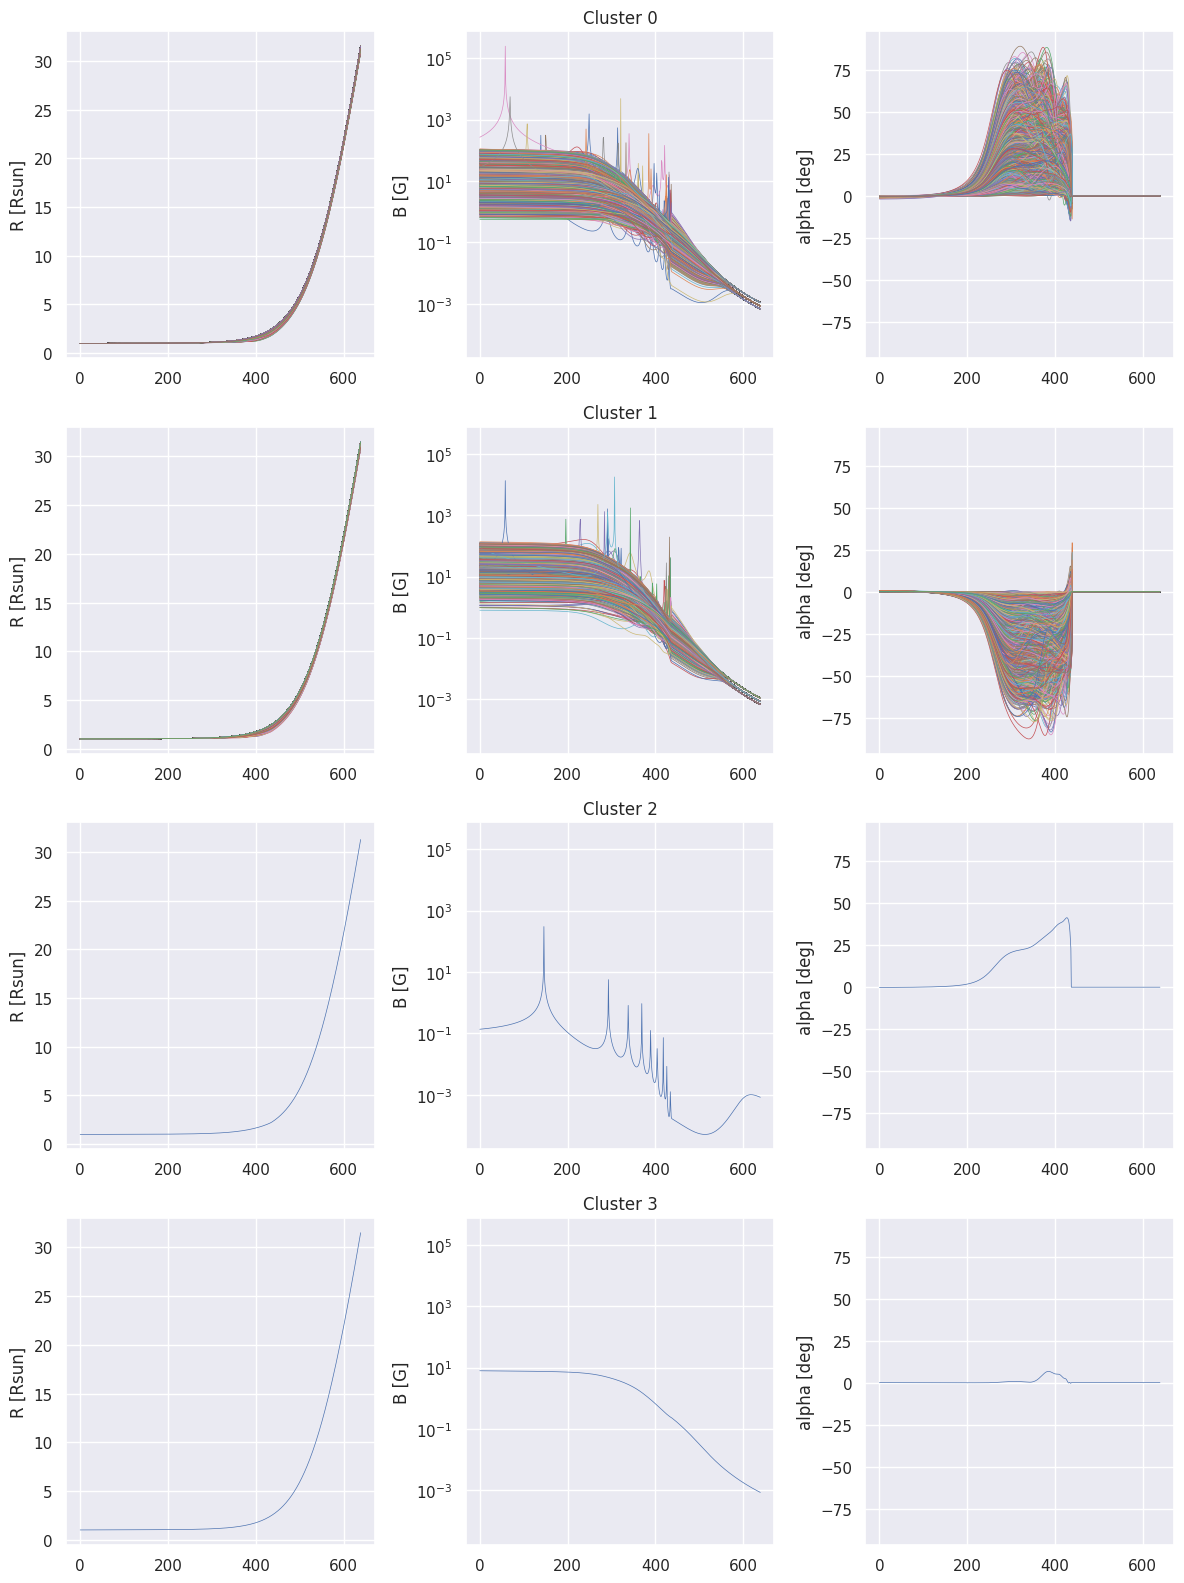

In [54]:
plot_unscaled_clusters(agg.labels_, nclusters, flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

<AxesSubplot: ylabel='count'>

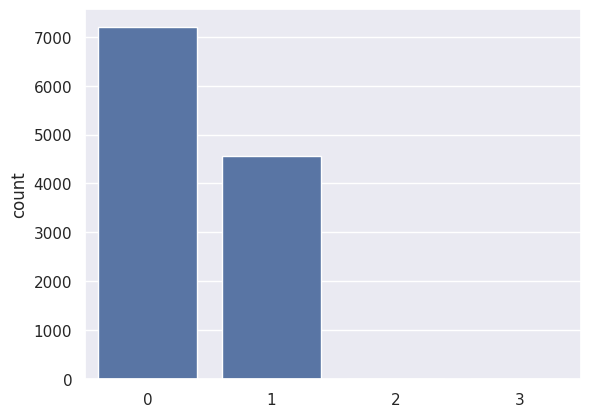

In [55]:
sns.countplot(x=agg.labels_, color='b')

In [56]:
# %%capture
# sub_dir = OUT_DIR / 'alpha'
# if not sub_dir.exists():
#     sub_dir.mkdir()
    
# for i in range(2, MAX_CLUSTERS):
#     agg = AgglomerativeClustering(compute_distances=True, n_clusters=i, compute_full_tree=True, linkage='average')
#     agg = agg.fit(transformed_alpha)
    
#     sp = sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1], hue=agg.labels_, palette='Set1')
    
        
#     plt.savefig(sub_dir / f'hierarch_scatter_{len(set(agg.labels_))}.png', dpi=200)
    
#     plot_unscaled_clusters(agg.labels_, len(set(agg.labels_)), flows_dict, flow_columns, 
#                            save_path=sub_dir / f'hierarch_{len(set(agg.labels_))}.png', yscale={'B [G]': 'log'}) 
    

## DBSCAN

In [57]:
dbscan = DBSCAN(eps=0.25, min_samples=10, n_jobs=2)
dbscan_mag_inc_labels = dbscan.fit_predict(transformed_mag_inc)
nclusters = len(set(dbscan_mag_inc_labels))


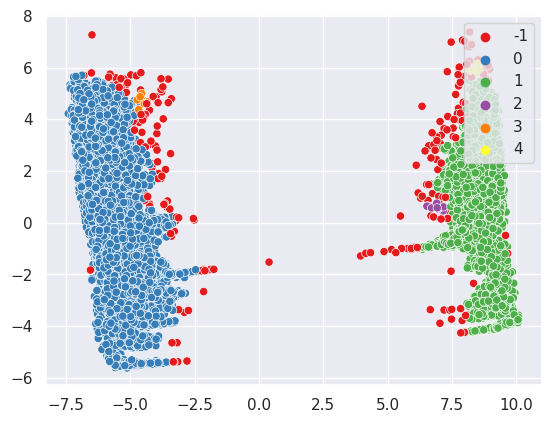

In [58]:
sp = sns.scatterplot(x=transformed_mag_inc[:, 0], y=transformed_mag_inc[:, 1], hue=dbscan_mag_inc_labels, palette='Set1')
plt.legend(loc='upper right')

### Original Data

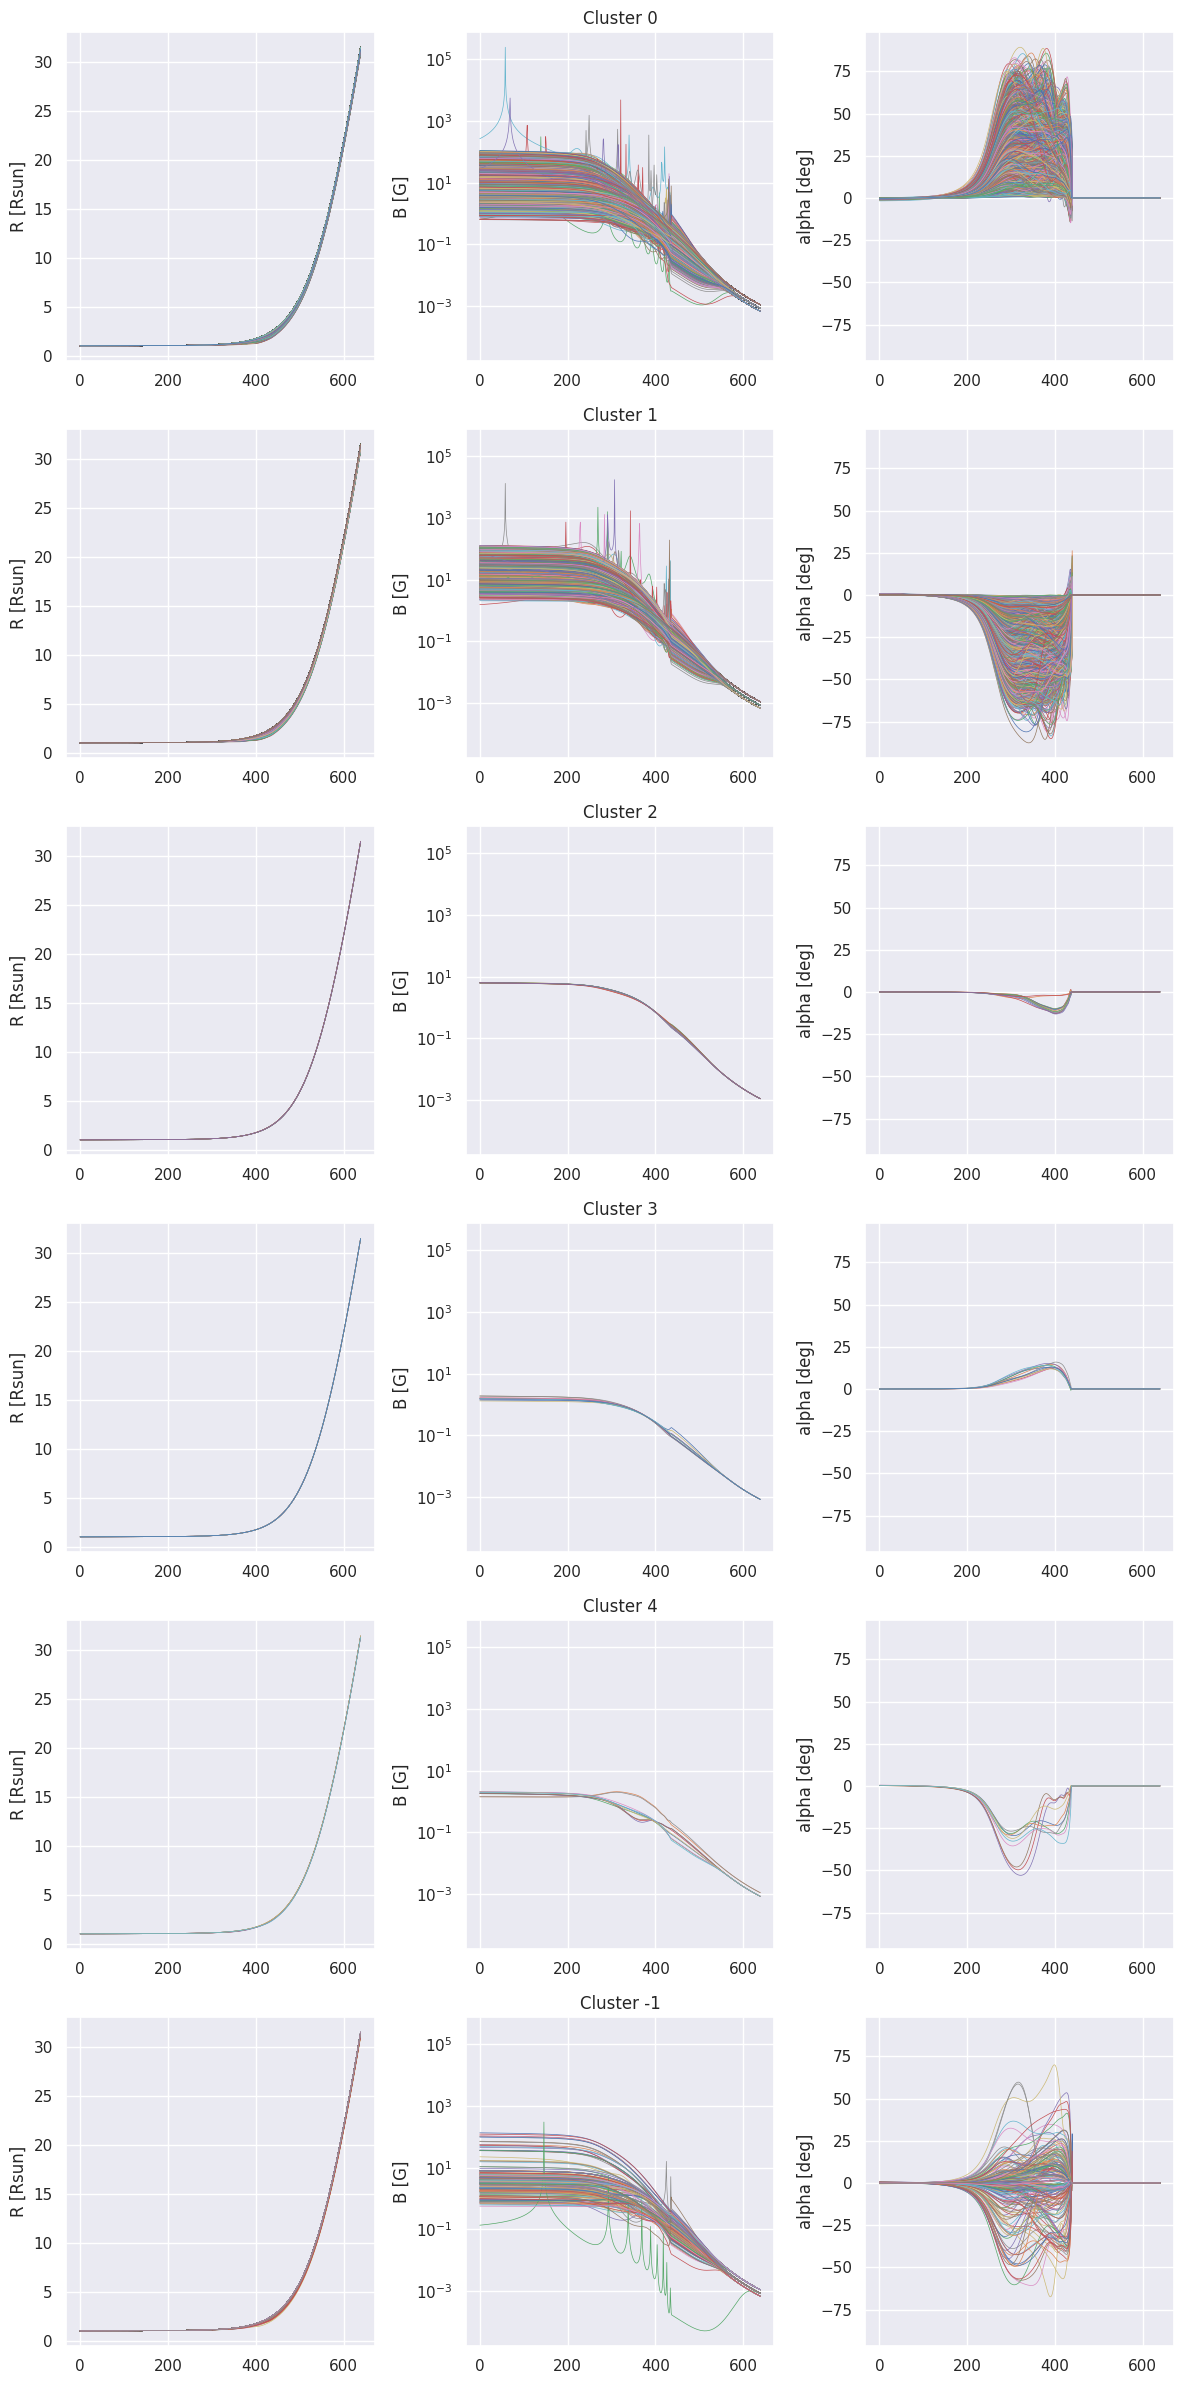

In [59]:
plot_unscaled_clusters(dbscan_mag_inc_labels, nclusters, flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

<AxesSubplot: ylabel='count'>

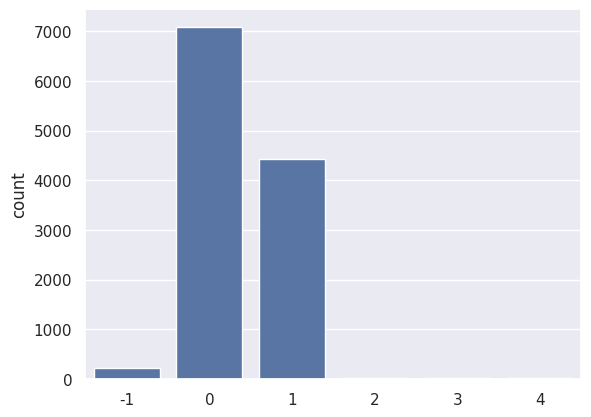

In [60]:
sns.countplot(x=dbscan_mag_inc_labels, color='b')

In [61]:
# %%capture
# sub_dir = OUT_DIR / 'alpha_dbscan'
# if not sub_dir.exists():
#     sub_dir.mkdir()
# for i in np.arange(0.2, 0.5, 0.05):
#     dbscan = DBSCAN(eps=i, min_samples=10, n_jobs=2)
#     dbscan_alpha_labels = dbscan.fit_predict(transformed_alpha)
    
#     save_i = int(round(i, 2) *100)
#     sp = sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1], hue=dbscan_alpha_labels, palette='Set1')
#     plt.legend(loc='upper right')
#     plt.savefig(sub_dir / f'dbscan_scatter_{save_i}.png', dpi=200)
    
#     plot_unscaled_clusters(dbscan_alpha_labels, len(set(dbscan_alpha_labels)), flows_dict, flow_columns, save_path=sub_dir / f'dbscan_{save_i}.png')
    